In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy import stats, optimize
from scipy import linalg as scilin
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import sympy as sym

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
sym.init_printing()

## Setup the True Parameters /  Simulation Parameters

In [3]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'c': .1,
               'delta': 1.22,
               'rho': .6,
                'time_dim':3000}

## Setup the linking functions.

In [4]:
x, y, rho, c, delta, phi, psi = sym.symbols('x y rho c delta phi psi')

In [5]:
theta, pi = sym.symbols('theta pi')
psi = phi / sym.sqrt(c + (1 + rho)) + (( 1 - phi**2) / 2 - (1 - phi**2) * theta)
a_func = rho * x / ( 1 + c * x)
alpha = psi * x + (( 1 -phi**2) / 2) * x**2
b_func = delta * sym.log(1 + c * x)
beta = a_func.replace(x, pi + alpha.replace(x, theta - 1)) - a_func.replace(x, pi + alpha.replace(x, theta)) 
gamma = b_func.replace(x, pi + alpha.replace(x, theta-1)) - b_func.replace(x, pi + alpha.replace(x, theta))

In [6]:
gamma_lambda = sym.lambdify((rho, c, delta, phi, pi, theta), gamma)
beta_lambda = sym.lambdify((rho, c, phi, pi, theta), beta)
psi_lambda = sym.lambdify((rho,c, phi,  theta), psi)

## Setup the Simulation Functions

In [7]:
def simulate_autoregressive_gamma(rho=0, c=1, delta=1, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function provides draws from the ARG(1) process of Gourieroux & Jaiak
    
    Parameters
    --------
    rho : scalar
        AR(1) coefficient
    delta : scalar
        intercept
    c : scalar
        scale
    Returns
    -----
    draws : dataframe
    """
    
    # If initial_point is not specified, we start at the unconditional mean.
    
    initial_point = (c * delta) / (1 - rho)
    
    # The conditional distribution of an ARG(1) process is non-centered Gamma, which has a representation as a 
    # Poisson mixture of Gamma
    
    draws = [initial_point]
    
    for _ in tqdm_notebook(range(time_dim)):
        
        latent_var = stats.poisson.rvs(mu = rho * draws[-1] / c)
        draws.append(stats.gamma.rvs(a=delta+latent_var, scale=c))
    
    draws = pd.DataFrame(draws[1:], pd.date_range(start=state_date, freq='D', periods=time_dim))
    return draws
    
    

In [8]:
def simulate_conditional_gaussian(vol_data, rho=0, c=1, delta=1, phi=0, vol_price=0, equity_price=1):
    """
    This function simulates conditional Gaussian random variables with mean
    
    $$E[r_{t+1} | \sigma^2_t, \sigma^2_{t+1}] = \psi \sigma^2_{t+1} + \beta \sigma^2_t + \gamma$$
    $$Var[r_{+t} | \sigma^2_t, \sigma^2_{t+1}] = (1 - \phi^2) \sigma^2_{t+1}$$
    
    Parameters
    ----------
    vol_data : pandas dataframe
        The volatility data. It must always be positive.
    rho : scalar
    c : scalar
    delta : scalar
    phi : scalar 
        It must be in [-1,1]
    vol_price : scalar
    equity_price : scalar
    
    Returns
    -------
    data : pandas dataframe 
        This contains both the vol_data and the return data
    """
    
    gamma = gamma_lambda(rho, c, delta, phi, vol_price, equity_price)
    beta = beta_lambda(rho, c, phi, vol_price, equity_price)
    psi = psi_lambda(rho,c, phi, equity_price)
    
    mean = gamma + beta * vol_data.shift(1) + psi * vol_data
    var = (1 - phi**2) * vol_data
    
    draws =  mean + pd.DataFrame(stats.norm.rvs(0, scale=var.apply(np.sqrt)),
                                 index=vol_data.index)
    data = pd.concat([vol_data, draws], axis=1).dropna()
    data.columns = ['vol', 'rtn']
    
    return data

In [9]:
def simulate_data(equity_price=1, vol_price=0, rho=0, c=1, delta=1, phi=0, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function takes the reduced-form paramters and risk prices and returns the data
    
    Parameters
    --------
    equity_price: scalar
    vol_price : scalar
    phi : scalar
        leverage
    rho : scalar
        persistence
    c : positive scalar
        scale
    initial_point: scalar, optional
        Starting value for the volatility
    time_dim : int, optional
        number of periods
    start_date : datelike, optional
        The time to start the data from.
        
    Returns
    -----
    draws : dataframe
    
    """
    vol_data = simulate_autoregressive_gamma(rho=rho, c=c, delta=1, initial_point=initial_point,
                                             state_date=pd.to_datetime(state_date) - pd.Timedelta('1 day'),
                                             time_dim=time_dim + 1)
    data = simulate_conditional_gaussian(vol_data, rho=rho, c=c, delta=delta, phi=phi, vol_price=vol_price,
                                         equity_price=equity_price)

    return data

## We now examine the distributions of simulated data

In [10]:
data = simulate_data(**true_params)

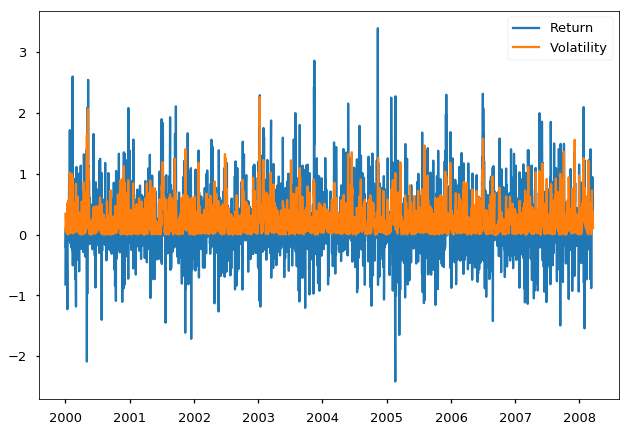

In [11]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()
# ax1.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1,6)))
# ax1.xaxis.set_major_formatter(mpl.dates.AutoDateFormatter(ax1.xaxis.get_major_locator()))


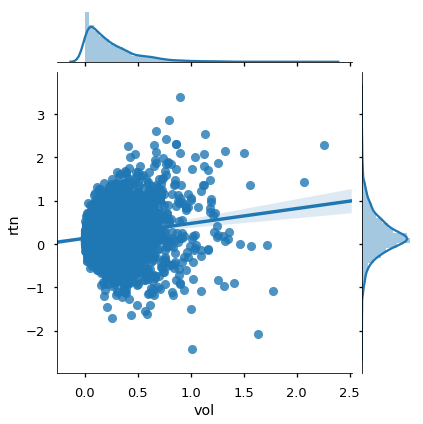

In [12]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [13]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.249965,0.214258
std,0.249923,0.515263
min,0.000021,-2.415875
25%,0.069080,-0.062771
50%,0.176241,0.164674
75%,0.349739,0.471194
max,2.260278,3.394080


## We now define the moment conditions that we can use to estimate volatility

In [14]:
mean = rho * x + c * delta
var = 2 * c * rho * x + c**2 * delta
mom1 = y - mean
mom2 = (y- mean) * x
mom3 = (y**2 - (var + mean**2))
mom4 = (y**2 - (var + mean**2)) * x
mom5 = (y**2 - (var + mean**2)) * x**2

In [15]:
vol_moments_sym = sym.Matrix([mom1,mom2, mom3, mom4, mom5])
vol_moments_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym)

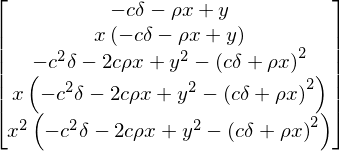

In [16]:
vol_moments_sym

In [17]:
def vol_moments(vol_data, *args):    
    return pd.DataFrame(np.squeeze(vol_moments_lambda(vol_data.values[1:], vol_data.values[:-1], *args)).T)

I use Sympy to compute the gradient

In [18]:
vol_squared_mom = vol_moments_sym.T @ vol_moments_sym
vol_squared_mom_grad = sym.lambdify((x, y, rho, c, delta), vol_squared_mom.jacobian([rho, c, delta]))

In [19]:
def vol_squared_moments_grad(vol_data, *args):
    return  pd.DataFrame(np.squeeze(vol_squared_mom_grad(vol_data.values[1:], vol_data.values[:-1], *args)).T, 
                         index=vol_data.index[1:]).dropna()

In [20]:
vol_moments_grad_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym.jacobian([rho, c, delta]))


In [21]:
def vol_moments_grad(vol_data, *args):
    mom_grad_in  = vol_moments_grad_lambda(vol_data.shift(-1), vol_data, *args)
    return np.array([[np.nanmean(arr_in) for arr_in in arr_out] for arr_out in mom_grad_in])
                         

In [22]:
intercept, persistence = tsa.AR(data.vol).fit(maxlag=1).params
error_var = tsa.AR(data.vol).fit(maxlag=1).sigma2
tsa.AR(data.vol).fit(maxlag=1).conf_int()

,0,1
const,0.092522,0.112984
L1.vol,0.559753,0.617637


From the model, we know that intercept = $ c * \delta$. We also know that the average error variance equals 
$ c^2 \delta * (2 \rho / 1 - \rho) + 1)$ Consequently, $c = error\_var / ( intercept * (2 \rho / 1 - \rho) + 1)) $ and delta = intercept / c


In [23]:
init_constants = {'rho': persistence}

In [24]:
init_constants['c'] = error_var / ( intercept * ( 2 * persistence / ( 1- persistence) + 1) )
init_constants['delta'] = intercept / init_constants['c']

In [25]:
num_vals = 50
cvals = np.linspace(0, 1,num_vals)
deltavals = np.linspace(0,1.5,num_vals)

In [26]:
plot_data = pd.DataFrame(np.asarray([(scale, intercept, vol_moments(data.vol, *[.5, scale, intercept]).apply(
    np.square).sum().mean())
     for scale, intercept in product(cvals, deltavals)]), columns=['c', 'delta', 'z'])
reshaped_x = plot_data.c.values.reshape((num_vals,num_vals))
reshaped_y = plot_data.delta.values.reshape((num_vals,num_vals))
reshaped_z = plot_data.z.values.reshape((num_vals,num_vals))

Text(0.5,0,'c')

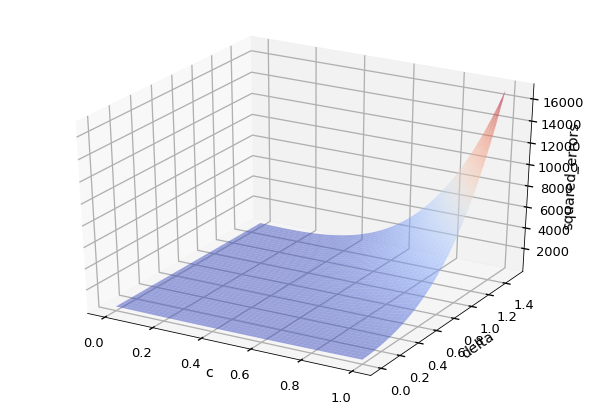

In [27]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(reshaped_x, reshaped_y, reshaped_z , cmap=cm.coolwarm, alpha=.5)


ax.set_ylabel('delta')
ax.set_zlabel('squared_errors')
ax.set_xlabel('c')
# ax.set_zlim(0, 1000)


In [28]:
def compute_vol_gmm(vol_data, x0, bounds=None):
    """
    This function uses GMM to compute the volatility paramters and their asymptotic covariance matrix.
    
    Paramters
    ---------
    vol_data : pandas series
    x0 : 3-element vector
    bounds : list
    
    Returns
    --------
    final_result : dict
    cov : ndarray
    """
    if bounds is None:
        bounds = [(-1+1e-5,1-1e-5),(1e-5, 20), (1e-5,20)]
    
    initial_result = optimize.minimize(lambda x: np.mean(np.ravel(vol_moments(vol_data, *x))**2),
                                       x0=list(init_constants.values()), method="SLSQP", bounds=bounds,
                                       options={'maxiter':200}, 
                                       jac= lambda x: np.mean(vol_squared_moments_grad(vol_data, *x), axis=0))
    
    weight_matrix = scilin.inv(vol_moments(vol_data, *initial_result.x).cov())
    root_weight_matrix = scilin.cholesky(weight_matrix)
    
    final_result = optimize.minimize(lambda x:
                                     np.mean(np.ravel((vol_moments(vol_data, *x) @ root_weight_matrix)**2)),
                           x0=initial_result.x, method="SLSQP", bounds=bounds, options={'maxiter':200})

    moment_derivative = vol_moments_grad(vol_data, *final_result.x)
    cov = np.linalg.inv(moment_derivative.T @ weight_matrix @ moment_derivative)

    return final_result, cov / (vol_data.size -1)


In [29]:
final_result, final_cov = compute_vol_gmm(data.vol, x0=init_constants)

In [30]:
final_result

     fun: 8.724862602975838
     jac: array([ 0.0001632 ,  0.00098658,  0.00022197])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.6100001 ,  0.10385403,  0.95853162])

In [31]:
true_values = [true_params[key] for key in ['rho', 'c', 'delta']]
lower_ci = final_result.x - 1.96 * np.sqrt(np.diag(final_cov))
upper_ci = final_result.x + 1.96 * np.sqrt(np.diag(final_cov))
estimates = pd.DataFrame(np.column_stack([true_values, final_result.x, lower_ci, upper_ci]),
             columns = ['truth', 'estimate', 'lower ci', 'upper ci'], index=['rho', 'c', 'delta'] )

In [32]:
estimates

,truth,estimate,lower ci,upper ci
rho,0.60,0.610000,0.570860,0.649140
c,0.10,0.103854,0.095910,0.111798
delta,1.22,0.958532,0.880379,1.036684


In [33]:
estimate_corr = pd.DataFrame(np.atleast_2d(np.diag(final_cov))**(-1/2) * final_cov
                             * np.atleast_2d(np.diag(final_cov)).T**(-1/2),
                            index=['rho', 'c', 'delta'], columns=['rho', 'c', 'delta'])

In [34]:
estimate_corr

,rho,c,delta
rho,1.000000,-0.270733,-0.463659
c,-0.270733,1.000000,-0.433679
delta,-0.463659,-0.433679,1.000000


## We now turn to estimating the reduced form paramters 

$$ r_{t+1} = \gamma + \beta \sigma^2_t + \psi \sigma^2_{t+1} + \sigma_{t+1} \sqrt{1-\phi^2} \eta_t $$

In [35]:
ols_results = sm.OLS.from_formula('rtn ~ 1+ vol.shift(1) + vol', data=data).fit()

In [36]:
ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.128    
Dependent Variable: rtn              AIC:                4123.6800
Date:               2018-08-09 16:43 BIC:                4141.6981
No. Observations:   2999             Log-Likelihood:     -2058.8  
Df Model:           2                F-statistic:        220.6    
Df Residuals:       2996             Prob (F-statistic): 4.36e-90 
R-squared:          0.128            Scale:              0.23134  
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept       0.0455    0.0132   3.4484  0.0006   0.0196   0.0714
vol.shift(1)    0.8080    0.0435  18.5843  0.0000   0.7227   0.8932
vol            -0.1317    0.0435  -3.0301  0.0025  -0.2170  -0.0465
------------------------------------------------------------------
Omnibus:             203.891       Durbin-Watson:          2.030  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       965.764
Skew:                -0.082        Prob(JB):               0.000  
Kurtosis:            5.775         Condition No.:          7      
==================================================================

"""

We need to compute the asymptotic variance of our 'rsquared' measure. We use the delta measure. A straightforward calculation shows

$$ \hat{R}^2 = R^2_{0} - \frac{1}{T} \sum_{t=1}^T \frac{x_{t+1}'}{\sigma^2_{t+1}} (\hat{\beta} - \beta_0).$$

As a consequence, $\hat{R}^2$ is asymptotically distributed $N(0, V_R)$ where $V_R$ equals

$$\frac{1}{T} \sum_{t=1}^T\left(\frac{x_{t+1}'}{\sigma_{t+1}^2}\right) V_{\beta} \frac{1}{T} \sum_{t=1}^T \left(\frac{x_{t+1}}{\sigma^2_{t+1}}\right).$$

In the above, we assumed that the erorrs in the $\hat{R}^2$ and $\beta$ are asympotiticaly orthgonal. This is implied by the relationship between squared and level terms and the fact that everything is asymptotically Gaussian. This is what implies the asympotic covariance matrix does not have correlation terms with respect to its fourth component.

In [37]:
weight = np.mean(ols_results.model.exog.T / data.vol.values[1:], axis=1).T

In [38]:
r_squared_cov = weight.T @ ols_results.cov_params() @ np.atleast_2d(weight).T

In [39]:
reduced_form_cov = np.concatenate([np.concatenate([ols_results.cov_params(), np.zeros((3,1))], axis=1),
                                   np.atleast_2d([0,0,0, np.asscalar(r_squared_cov)])], axis=0)

In [40]:
reduced_form_paramters = {'beta':ols_results.params['vol.shift(1)'],
                          'gamma':ols_results.params['Intercept'],
                          'psi':ols_results.params['vol'],
                          'rsquared' :1 - (ols_results.resid**2 / data.vol).mean()
                         }

In [41]:
reduced_form_paramters

{'beta': 0.80796422363013565,
 'gamma': 0.045525901595620234,
 'psi': -0.1317329763679258,
 'rsquared': 0.061095751812378696}

In [42]:
reduced_form_cov

array([[  1.74298481e-04,  -1.94470139e-04,  -1.94205905e-04,
          0.00000000e+00],
       [ -1.94470139e-04,   1.89013998e-03,  -1.11264684e-03,
          0.00000000e+00],
       [ -1.94205905e-04,  -1.11264684e-03,   1.89002142e-03,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.35449321e-01]])

## This method only gives us the magnitude, not the sign.

In [43]:
phi_est = np.sqrt(1 - (ols_results.resid**2 / data.vol).mean())

In [44]:
print("The true phi is {} and the phi estiamte is {:.02f}".format(true_params['phi'], phi_est))

The true phi is -0.17 and the phi estiamte is 0.25


## I now setup the second-stage derivation

In [45]:
second_stage_moments_sym = sym.Matrix([beta,gamma, psi, phi**2])
second_stage_moments_lambda = sym.lambdify((rho, c, delta, phi, theta, pi), second_stage_moments_sym)

Note, since g (the link function) = (beta, gamma, psi, phi^2), the Jacobian is diagonal with [1,1,1,2 * phi] as that diagonal

In [46]:
def link_grad1(phi):
    return np.diag([1,1,1, 2*phi])

In [47]:
link2_grad_lambda = sym.lambdify((rho, c, delta, phi, pi, theta), 
                                  second_stage_moments_sym.jacobian([pi, theta, phi]))

In [48]:
link2_grad_lambda(rho=.9, c=.1,delta=1.22, phi=-.17, pi=-7, theta=.4)

array([[ -7.07125655e-01,   1.63332964e-02,  -6.48795665e+00],
       [ -1.49888078e-02,   3.46213773e-04,  -2.75394480e-01],
       [  0.00000000e+00,  -9.71100000e-01,   7.41106781e-01],
       [  0.00000000e+00,   0.00000000e+00,  -3.40000000e-01]])

In [49]:
def second_criterion(x, rho, c, delta, beta, gamma, psi, rsquared, weight=np.eye(4)):
    
    phi_in, vol_price, equity_price = x
    
    part1 = second_stage_moments_lambda(rho=rho, c=c, delta=delta, theta=equity_price, phi=phi_in, 
                                        pi=vol_price).ravel()
    part2 = np.array([beta, gamma, psi, rsquared])
    
    diff = part1 - part2
            
    return .5 * diff @ weight @ diff
    

In [50]:
reduced_form_paramters

{'beta': 0.80796422363013565,
 'gamma': 0.045525901595620234,
 'psi': -0.1317329763679258,
 'rsquared': 0.061095751812378696}

We sometimes get invalid values inside the logarithm for non-optimal values. This would induce a complicated nonlinear constraint for the valid values of the volatilty risk price, but they do not bind, and so we don't bother imposing them.

In [51]:
def compute_stage2_weight(reduced_form_cov, phi):
    return  np.linalg.inv(link_grad1(phi).T @ reduced_form_cov @ link_grad1(phi).T)

In [52]:
def est_2nd_stage(reduced_form_cov, bounds=None, opts=None):
    
    if bounds is None:
        bounds = ([-1,1], [-50, 50], [0, 10])
    if opts is None:
        opts = {'maxiter':200}
    
    init_result = optimize.minimize(lambda x: second_criterion(x, **reduced_form_paramters, **estimates.estimate),
                                       x0=[0,1,0], method="SLSQP",  options=opts, bounds=bounds)
    weight = compute_stage2_weight(reduced_form_cov=reduced_form_cov, phi=init_result.x[0])
    
    final_result = optimize.minimize(lambda x: second_criterion(x, weight=weight, **reduced_form_paramters, 
                                                                **estimates.estimate), x0=init_result.x, 
                                     method="SLSQP",  options=opts, bounds=bounds)
                  
    return final_result

In [53]:
final_cov

array([[  3.98776409e-04,  -2.19125196e-05,  -3.69189842e-04],
       [ -2.19125196e-05,   1.64274975e-05,  -7.00875384e-05],
       [ -3.69189842e-04,  -7.00875384e-05,   1.58991187e-03]])

In [54]:
 stage2_result = est_2nd_stage(reduced_form_cov)

<string>:2: RuntimeWarning: invalid value encountered in log


In [55]:
stage2_result

     fun: 0.0015258387809896994
     jac: array([ 0.02005681,  0.00285346,  0.00130959])
 message: 'Optimization terminated successfully.'
    nfev: 89
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-0.21879643, -6.33169088,  0.46362276])

In [56]:
structural_est = {'phi': stage2_result.x[0], 'vol_price':stage2_result.x[1], 'equity_price':stage2_result.x[2]}

In [57]:
structural_est

{'phi': -0.21879642703018345,
 'vol_price': -6.3316908847062496,
 'equity_price': 0.46362275910597356}

In [58]:
true_params

{'equity_price': 0.5,
 'vol_price': -7,
 'phi': -0.17,
 'c': 0.1,
 'delta': 1.22,
 'rho': 0.6,
 'time_dim': 3000}

## I now compute the covariance matrix for this 2nd stage regression

I first compute the bread for the sandwich

In [59]:
g_at_est = second_stage_moments_lambda(pi=structural_est['vol_price'], theta=structural_est['equity_price'],
                                phi=structural_est['phi'], rho=estimates.estimate['rho'], 
                                c=estimates.estimate['c'], delta=estimates.estimate['delta'])

In [60]:
opt_weight_matrix = compute_stage2_weight(reduced_form_cov, structural_est['phi'])

This is a scalar

In [61]:
B = g_at_est.T @ opt_weight_matrix @ g_at_est

In [62]:
g_deriv_structural = link2_grad_lambda(rho=estimates.estimate['rho'], c=estimates.estimate['c'], 
                             delta=estimates.estimate['delta'], phi=structural_est['phi'],
                             pi=structural_est['vol_price'], theta=structural_est['equity_price'])

In [69]:
cov_2nd_stage = B**(-1) * g_deriv_structural.T @ opt_weight_matrix @ g_deriv_structural * B**(-1)

In [70]:
structural_est

{'phi': -0.21879642703018345,
 'vol_price': -6.3316908847062496,
 'equity_price': 0.46362275910597356}

In [71]:
struct_est_df = pd.Series(list(structural_est.values()), index=structural_est.keys())

In [72]:
true_values = pd.Series([true_params[key] for key in structural_est.keys()], index=structural_est.keys())
lower_ci = struct_est_df - 1.96 * pd.Series(np.sqrt(np.diag(cov_2nd_stage)), index=struct_est_df.index)
upper_ci = struct_est_df + 1.96 * pd.Series(np.sqrt(np.diag(cov_2nd_stage)), index=struct_est_df.index)
estimates_2nd_stage = pd.concat([true_values, struct_est_df, lower_ci, upper_ci], axis=1)
estimates_2nd_stage.columns = ['truth', 'estimates', 'lower ci', 'upper_ci']

In [73]:
estimates_2nd_stage

,truth,estimates,lower ci,upper_ci
phi,-0.17,-0.218796,-0.232026,-0.205567
vol_price,-7.00,-6.331691,-6.339895,-6.323487
equity_price,0.50,0.463623,0.364326,0.562920
